# Initialization


## Importing the libraries

In [149]:
import numpy as np 
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import seaborn as sns
import plotly.express as px
%matplotlib inline
import scipy.stats
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)

## Loading the data

In [187]:
dropout = pd.read_excel(r"C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Education/data/dropout.xls")
enrollments = pd.read_excel(r"C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Education/data/enrollment.xls")
drinks = pd.read_excel(r"C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Education/data/drinking_water.xls")
computers = pd.read_excel(r"C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Education/data/computers.xls")
electricity = pd.read_excel(r"C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Education/data/electricity.xls")
boys_toilet = pd.read_excel(r"C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Education/data/boys_toilet.xls")
girls_toilet = pd.read_excel(r"C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Education/data/girls_toilet.xls")
ptr= pd.read_excel(r"C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Education/data/pupil_teacher.xls")

# Data preparation

In [151]:
def returner(xx):
    x=[]
    for i in range(36):
        x.append(xx[['State','All Schools']].loc[3*i])  
    x=pd.DataFrame(x)
    x.set_index('State', inplace=True)
    return x

In [152]:
enrollments['Higher_Secondary_Boys']=enrollments['Higher_Secondary_Boys'].astype('float')
enrollments['Higher_Secondary_Girls']=enrollments['Higher_Secondary_Girls'].astype('int')
enrollments['Higher_Secondary_Total']=enrollments['Higher_Secondary_Total'].astype('int')   
drinks=returner(drinks)
drinks.columns=['Drinking water']
electricity=returner(electricity)
electricity.columns=['Electricity']
computers=returner(computers)
computers.columns=["Computer"]
boys_t=returner(boys_toilet)
boys_t.columns=['Boys toilet']
girls_t=returner(girls_toilet)
girls_t.columns=['Girls toilet']
factors=pd.concat([drinks,electricity,computers,boys_t,girls_t],axis=1)
factors.reset_index(inplace=True)

In [153]:
states=[]
for i in range(36):
    states.append(dropout.State.iloc[3*i])
states=pd.DataFrame(states, columns=['State'])

def create_aggregate(inp):
    inp.drop(['State','Year'],axis=1,inplace=True)

    x=pd.DataFrame()
    for i in range(36):
        x[i]=inp.iloc[3*i+0:i*3+3,:].mean()
    x=x.transpose() 
    return x

In [154]:
dropouts_x = create_aggregate(dropout)
enrollments_x=create_aggregate(enrollments)

# Data exploration

In [155]:
print("\n Correlation between enrollment rates at different stages of schooling\n")
enrollments[['Primary_Total', 'Upper_Primary_Total', 'Secondary_Total','Higher_Secondary_Total']].corr(method='spearman').style.background_gradient(cmap='coolwarm')


 Correlation between enrollment rates at different stages of schooling



,Primary_Total,Upper_Primary_Total,Secondary_Total,Higher_Secondary_Total
Primary_Total,1.000000,0.691324,0.122769,-0.216003
Upper_Primary_Total,0.691324,1.000000,0.513059,0.076870
Secondary_Total,0.122769,0.513059,1.000000,0.659823
Higher_Secondary_Total,-0.216003,0.076870,0.659823,1.000000


### Observations
* There is moderate positive correlation between `primary` and `upper primary` dropouts
* There is moderate positive correlation between `secondary` and `higher secondary` dropouts

Probably in similar states students dropout during the lower classes, and in other similar states the dropout rate is higher in the upper classes.

In [156]:
print("\n Correlation between dropout rates at different stages of schooling\n")
dropout[['PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL']].corr(method='spearman').style.background_gradient(cmap='coolwarm')


 Correlation between dropout rates at different stages of schooling



,PRIMARY_TOTAL,UPPER_PRIMARY_TOTAL,SECONDARY_TOTAL,HRSECONDARY_TOTAL
PRIMARY_TOTAL,1.000000,0.748033,0.384132,-0.255152
UPPER_PRIMARY_TOTAL,0.748033,1.000000,0.605983,-0.144547
SECONDARY_TOTAL,0.384132,0.605983,1.000000,-0.183079
HRSECONDARY_TOTAL,-0.255152,-0.144547,-0.183079,1.000000


### Observations

* Dropouts in `primary` and `upper primary` are positively correlated. We need to do further analysis.

Text(0.5, 0.98, 'Analysis on dropout and enrollment rates')

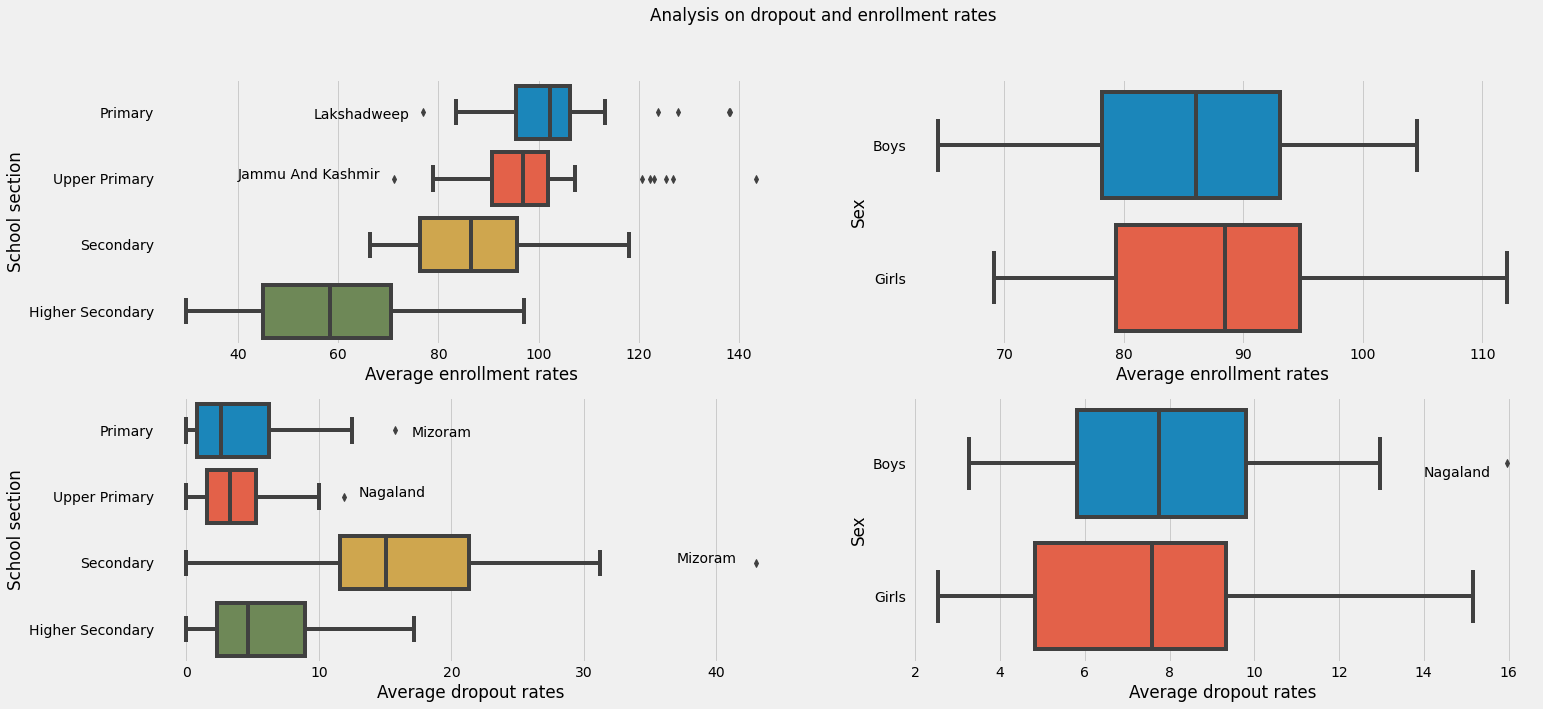

In [157]:
prim=['Primary']*36
uprim=['Upper Primary']*36
sec=['Secondary']*36
usec=['Higher Secondary']*36
lis=prim+uprim+sec+usec
lis
datas=pd.DataFrame({'values':pd.concat([enrollments_x['Primary_Total'],enrollments_x['Upper_Primary_Total'],enrollments_x['Secondary_Total'],enrollments_x['Higher_Secondary_Total']],axis=0), 'ID':lis, 'State':list(states['State'])*4})

enrollments_boys=(enrollments_x['Primary_Boys']+enrollments_x['Upper_Primary_Boys']+enrollments_x['Secondary_Boys']+enrollments_x['Higher_Secondary_Boys'])/4
enrollments_girls=(enrollments_x['Primary_Girls']+enrollments_x['Upper_Primary_Girls']+enrollments_x['Secondary_Girls']+enrollments_x['Higher_Secondary_Girls'])/4
boys=['Boys']*36
girls=['Girls']*36
sex=boys+girls
enrolls=pd.concat([enrollments_boys,enrollments_girls],axis=0)
datassex1=pd.DataFrame({'Enrollments':enrolls,'Sex':sex,'State':list(states['State'])*2})


datass=pd.DataFrame({'values':pd.concat([dropouts_x['PRIMARY_TOTAL'],dropouts_x['UPPER_PRIMARY_TOTAL'],dropouts_x['SECONDARY_TOTAL'],dropouts_x['HRSECONDARY_TOTAL']],axis=0), 'ID':lis,'State':list(states['State'])*4})

dropouts_boys=(dropouts_x['PRIMARY_BOYS']+dropouts_x['UPPER_PRIMARY_BOYS']+dropouts_x['SECONDARY_BOYS']+dropouts_x['HRSECONDARY_BOYS'])/4
dropouts_girls=(dropouts_x['PRIMARY_GIRLS']+dropouts_x['UPPER_PRIMARY_GIRLS']+dropouts_x['SECONDARY_GIRLS']+dropouts_x['HRSECONDARY_GIRLS'])/4

drops=pd.concat([dropouts_boys,dropouts_girls],axis=0)
datassex2=pd.DataFrame({'Dropouts':drops,'Sex':sex,'State':list(states['State'])*2})

fig,ax=plt.subplots(2,2,figsize=(22,10))

sns.boxplot(x='values',y='ID',data=datas,ax=ax[0,0])
ax[0,0].set_xlabel('Average enrollment rates')
ax[0,0].set_ylabel('School section')
#ax[0].suptitle('Comparison of enrollment rates across different sections of the school')

sns.boxplot(x='Enrollments',y='Sex',data=datassex1,ax=ax[0,1])
ax[0,1].set_xlabel('Average enrollment rates')
ax[0,1].set_ylabel('Sex')
#ax[1].suptitle('Comparison of enrollment rates across sex')

sns.boxplot(x='values',y='ID',data=datass,ax=ax[1,0])
ax[1,0].set_xlabel('Average dropout rates')
ax[1,0].set_ylabel('School section')
#plt.title('Comparison of dropout rates across different sections of the school')


sns.boxplot(x='Dropouts',y='Sex',data=datassex2,ax=ax[1,1])
ax[1,1].set_xlabel('Average dropout rates')
ax[1,1].set_ylabel('Sex')

low_prim=datas.State.iloc[datas['values'][datas['ID']=='Primary'].idxmin()]
up_prim=datas.State.iloc[datas['values'][datas['ID']=='Upper Primary'].idxmin()]


p_out=datass.State.iloc[datass['values'][datass['ID']=='Primary'].idxmax()]
up_out= datass.State.iloc[datass['values'][datass['ID']=='Upper Primary'].idxmax()]
sec_out=datassex2.State.iloc[datass['values'][datass['ID']=='Primary'].idxmax()]
boys_out=datassex2.State.iloc[datassex2['Dropouts'][datassex2['Sex']=='Boys'].idxmax()]


ax[0,0].text(55,0.1,s=low_prim)
ax[0,0].text(40,1,s=up_prim)
ax[1,0].text(17,0.1,s=p_out)
ax[1,0].text(13,1,s=up_out)
ax[1,0].text(37,2,s=sec_out)
ax[1,1].text(14,0.1,s=boys_out)

plt.suptitle("Analysis on dropout and enrollment rates")

## Student to teacher ratio

Text(0.5, 1.0, 'Student to teacher ration in different sections of the school')

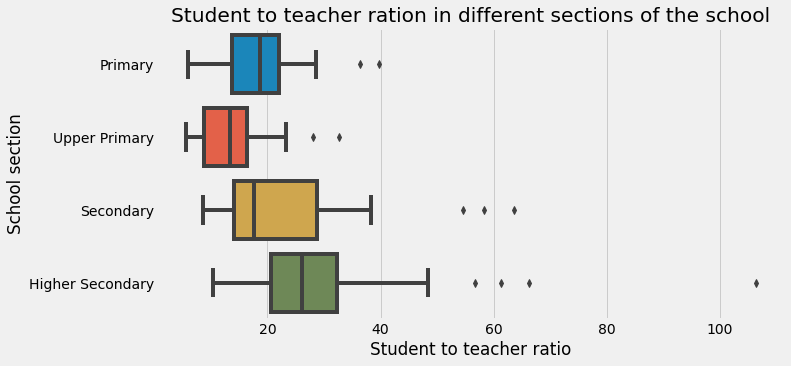

In [199]:
prim=['Primary']*36
uprim=['Upper Primary']*36
sec=['Secondary']*36
usec=['Higher Secondary']*36
lis=prim+uprim+sec+usec
lis
datas=pd.DataFrame({'values':pd.concat([ptr['Primary'],ptr['Upper Primary'],ptr['Secondary'],ptr['Higher Secondary']],axis=0), 'ID':lis, 'State':list(states['State'])*4})
plt.figure(figsize=(10,5))
sns.boxplot(data=datas, x='values', y='ID')
plt.xlabel('Student to teacher ratio')
plt.ylabel('School section')
plt.title('Student to teacher ration in different sections of the school')

## Other factors in schooling

In [158]:
factors.corr(method='spearman').style.background_gradient(cmap="coolwarm")

,Drinking water,Electricity,Computer,Boys toilet,Girls toilet
Drinking water,1.000000,0.865238,0.748390,0.696139,0.636747
Electricity,0.865238,1.000000,0.878351,0.642424,0.704691
Computer,0.748390,0.878351,1.000000,0.648551,0.690509
Boys toilet,0.696139,0.642424,0.648551,1.000000,0.874460
Girls toilet,0.636747,0.704691,0.690509,0.874460,1.000000


In [159]:
prim=['Drinking water']*36
uprim=['Electricity']*36
uuprim=['Computer']*36
sec=['Boys toilet']*36
usec=['Girls toilet']*36
lis=prim+uprim+uuprim+sec+usec
lis
datas=pd.DataFrame({'values':pd.concat([factors['Drinking water'],factors['Electricity'],factors['Computer'],factors['Boys toilet'], factors['Girls toilet']],axis=0), 'ID':lis,'State':list(states['State'])*5})

px.box(data_frame=datas,x='values', y='ID',hover_name='State',color='ID')


## Clustering

In [160]:
def create_clusters(inx):

    scores=[]
    for i in range(2,36):
        k=KMeans(n_clusters=i,n_init=500, max_iter=500)
        k.fit(inx)
        label=KMeans.predict(k,inx)
        scores.append(silhouette_score(inx, label))

    pd.DataFrame(scores).plot()
    best_cluster_no=np.argmax(scores)+2

    plt.axvline(best_cluster_no)
    plt.text(best_cluster_no, 0.34,s=f"Max silhoutte score at n={best_cluster_no}")
    plt.xlabel("No. of clusters")
    plt.ylabel("Silhoutte score")
    kk=KMeans(n_clusters=best_cluster_no)

    kk.fit(inx)
    lab = pd.DataFrame(kk.labels_,columns=['Labels'])
    result=pd.concat([states['State'],inx,lab['Labels']],axis=1)
    return result

In [161]:
def return_clusters(result):
    grouping=result[['State','Labels']]
    clusters=pd.DataFrame()
    for l in grouping.Labels.unique():
        clusters=pd.concat([clusters,pd.Series(np.array(grouping.State[grouping.Labels==l]), name=f"Cluster {l}").to_frame()],axis=1)
    clusters.replace({np.nan:'-'},inplace=True)
    clusters.sort_index(axis=1, inplace=True)    
    return clusters

# Hypothesis testing

## Dropouts

We are going to check if the dropout rates of
* girls are significantly different from boys
* different sections of the school are different

In [162]:
g_m,g_sd=dropouts_girls.mean(), dropouts_girls.std()
b_m,b_sd=dropouts_boys.mean(), dropouts_boys.std()

Z = (g_m-b_m)/(g_sd**2/36+b_sd**2/36)

#find p-value for two-tailed test
p=scipy.stats.norm.sf(abs(Z))*2
p

0.17289607657453654

There is a 17% chance of boys' and girls' dropout rates being same

In [163]:
F, p = scipy.stats.f_oneway(dropouts_x['PRIMARY_TOTAL'],dropouts_x['UPPER_PRIMARY_TOTAL'],dropouts_x['SECONDARY_TOTAL'],dropouts_x['HRSECONDARY_TOTAL'])
# Seeing if the overall model is significant
print('F-Statistic=%.3f, p=%.3f' % (F, p))

F-Statistic=45.282, p=0.000


## Enrollments

In [164]:
g_m,g_sd=enrollments_girls.mean(), enrollments_girls.std()
b_m,b_sd=enrollments_boys.mean(), enrollments_boys.std()

Z = (g_m-b_m)/(g_sd**2/36+b_sd**2/36)

#find p-value for two-tailed test
p=scipy.stats.norm.sf(abs(Z))*2
p

0.7276748223195866

There is a 72% chance of boys' and girls' enrollment rates being same

In [165]:
F, p = scipy.stats.f_oneway(enrollments_x['Primary_Total'],enrollments_x['Upper_Primary_Total'],enrollments_x['Secondary_Total'],enrollments_x['Higher_Secondary_Total'])
# Seeing if the overall model is significant
print('F-Statistic=%.3f, p=%.3f' % (F, p))

F-Statistic=58.335, p=0.000


## Other factors

In [166]:
F, p = scipy.stats.f_oneway(factors['Drinking water'],factors['Electricity'],factors['Computer'],factors['Boys toilet'],factors['Girls toilet'])
# Seeing if the overall model is significant
print('F-Statistic=%.3f, p=%.3f' % (F, p))

F-Statistic=43.897, p=0.000


# Analysis

In [167]:
dropouts_x=dropouts_x[['PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL']]
enrollments_x=enrollments_x[['Primary_Total', 'Upper_Primary_Total', 'Secondary_Total','Higher_Secondary_Total']]
factors.drop(['State'],axis=1,inplace=True)

In [168]:
dataset=pd.concat([dropouts_x,enrollments_x,factors],axis=1)
cols=[]
for col in dataset.columns[:4]:
    cols.append("Dropout-"+col[:-6])
for col in dataset.columns[4:8]:
    cols.append("Enrollments-"+col[:-6])
for col in dataset.columns[8:]:
    cols.append(col)  
dataset.columns=cols

In [169]:
dataset.head(5)

,Dropout-PRIMARY,Dropout-UPPER_PRIMARY,Dropout-SECONDARY,Dropout-HRSECONDARY,Enrollments-Primary,Enrollments-Upper_Primary,Enrollments-Secondary,Enrollments-Higher_Secondary,Drinking water,Electricity,Computer,Boys toilet,Girls toilet
0,0.800000,1.143333,7.543333,15.646667,91.260000,87.863333,93.243333,90.000000,98.69,88.86,53.06,94.52,93.44
1,4.750000,4.113333,13.693333,4.046667,89.810000,81.456667,74.370000,57.000000,90.35,90.34,29.57,56.88,81.31
2,12.290000,6.590000,14.843333,13.533333,127.783333,122.200000,89.300000,64.666667,79.79,36.35,24.28,48.73,76.90
3,9.680000,8.253333,28.086667,3.976667,111.500000,94.013333,74.526667,34.333333,80.30,19.39,8.85,60.17,75.28
4,0.696667,2.353333,27.123333,0.000000,102.240000,97.733333,69.180000,29.666667,92.53,9.96,5.47,73.42,75.41


In [170]:
dataset.corr(method='spearman').style.background_gradient(cmap='coolwarm')

,Dropout-PRIMARY,Dropout-UPPER_PRIMARY,Dropout-SECONDARY,Dropout-HRSECONDARY,Enrollments-Primary,Enrollments-Upper_Primary,Enrollments-Secondary,Enrollments-Higher_Secondary,Drinking water,Electricity,Computer,Boys toilet,Girls toilet
Dropout-PRIMARY,1.000000,0.808626,0.433988,-0.326441,0.546122,0.140328,-0.348632,-0.430200,-0.798247,-0.718789,-0.614355,-0.535910,-0.429225
Dropout-UPPER_PRIMARY,0.808626,1.000000,0.684685,-0.245976,0.491634,0.171943,-0.469755,-0.650274,-0.640407,-0.595619,-0.549292,-0.590341,-0.480315
Dropout-SECONDARY,0.433988,0.684685,1.000000,-0.314359,0.302703,0.020849,-0.551866,-0.945864,-0.444591,-0.543557,-0.556757,-0.462975,-0.415749
Dropout-HRSECONDARY,-0.326441,-0.245976,-0.314359,1.000000,-0.139472,0.096330,0.235673,0.276393,0.256948,0.451580,0.497875,0.235696,0.301116
Enrollments-Primary,0.546122,0.491634,0.302703,-0.139472,1.000000,0.725354,0.090862,-0.209076,-0.586416,-0.481959,-0.426512,-0.408371,-0.275276
Enrollments-Upper_Primary,0.140328,0.171943,0.020849,0.096330,0.725354,1.000000,0.461776,0.069520,-0.280033,-0.148969,-0.129215,-0.148616,0.032863
Enrollments-Secondary,-0.348632,-0.469755,-0.551866,0.235673,0.090862,0.461776,1.000000,0.695333,0.330924,0.456444,0.456628,0.259627,0.428636
Enrollments-Higher_Secondary,-0.430200,-0.650274,-0.945864,0.276393,-0.209076,0.069520,0.695333,1.000000,0.442021,0.524396,0.553717,0.373720,0.382429
Drinking water,-0.798247,-0.640407,-0.444591,0.256948,-0.586416,-0.280033,0.330924,0.442021,1.000000,0.865238,0.748390,0.696139,0.636747
Electricity,-0.718789,-0.595619,-0.543557,0.451580,-0.481959,-0.148969,0.456444,0.524396,0.865238,1.000000,0.878351,0.642424,0.704691


### Observations

* Dropouts are negatively correlated with factors. Children need more care. They need drinking water because they play a lot. If there isn't electricity, India primarily being a tropical country,discourage them to come to schools. WRITE BETTER AND FOR THE OTHER POINTS
* Correlation with dropouts reduces with increasing age of students
* Same thing observed in enrollments

## Checking feature importance

In [171]:
#Using SVD

vals=np.array(dataset)
u,sig,v_t=np.linalg.svd(vals)
feature_imp=pd.Series(sig,index=list(dataset.columns))
feature_imp.index.name="Feature"
feature_imp.name="Explained variance"
var_exp=pd.DataFrame(feature_imp)
tot=var_exp['Explained variance'].sum()
var_exp['Explained variance'] = var_exp['Explained variance']/tot*100
var_exp.sort_values(['Explained variance'],ascending=False,inplace=True)

exp_var=[]
for i in range(1,var_exp.shape[0]+1):
    exp_var.append(var_exp['Explained variance'].iloc[0:i].sum())
pd.concat([var_exp,pd.DataFrame(exp_var,index=var_exp.index, columns=['Cumulative explained variance'])],axis=1)

,Explained variance,Cumulative explained variance
Feature,,
Dropout-PRIMARY,67.467485,67.467485
Dropout-UPPER_PRIMARY,10.564140,78.031625
Dropout-SECONDARY,4.784083,82.815709
Dropout-HRSECONDARY,4.027713,86.843422
Enrollments-Primary,3.904819,90.748241
Enrollments-Upper_Primary,2.150093,92.898334
Enrollments-Secondary,1.967697,94.866031
Enrollments-Higher_Secondary,1.378449,96.244480
Drinking water,1.288027,97.532508


In [172]:
from sklearn.preprocessing import MinMaxScaler
mm=MinMaxScaler()
datasets=pd.DataFrame(mm.fit_transform(dataset),columns=list(dataset.columns))

# Overall ranking of states

In [173]:
states['Overall score']=datasets.mean(axis=1)
states.set_index('State').sort_values(['Overall score'],ascending=False) 

,Overall score
State,
Delhi,0.689531
Mizoram,0.651740
Sikkim,0.647587
Lakshadweep,0.600114
Chandigarh,0.580263
Manipur,0.574625
Puducherry,0.571594
Himachal Pradesh,0.569865
Goa,0.565119


# Finding out outliers

c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.25, 0.2, 'Bihar')

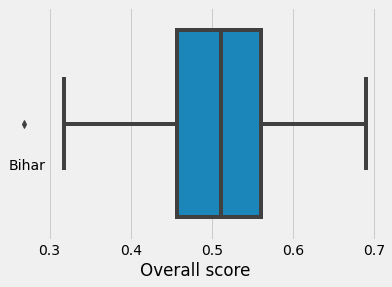

In [174]:
sns.boxplot(states['Overall score'])
plt.text(0.25,0.2,s=states.iloc[states['Overall score'].argmin()][0])

## Visualizing the data on the basis of top three features

In [175]:
import plotly.express as px
fig = px.scatter_3d(dataset, y='Dropout-PRIMARY', z='Dropout-UPPER_PRIMARY', x='Dropout-SECONDARY', opacity=0.7,text=states['State'])
fig.update_layout(width=1200, height=720)

Dropout rates define the maximum difference in education between the states